
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://static.mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy-webpage/v0.17?urlpath=lab/tree/modeling.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[modeling.ipynb](../_static/notebooks/modeling.ipynb) |
[modeling.py](../_static/notebooks/modeling.py)
</div>


# Modeling and fitting


## Prerequisites

- Knowledge of spectral analysis to produce 1D On-Off datasets, [see the following tutorial](spectrum_analysis.ipynb)
- Reading of pre-computed datasets [see the MWL tutorial](analysis_mwl.ipynb)
- General knowledge on statistics and optimization methods

## Proposed approach

This is a hands-on tutorial to `~gammapy.modeling`, showing how the model, dataset and fit classes work together. As an example we are going to work with HESS data of the Crab Nebula and show in particular how to :
- perform a spectral analysis
- use different fitting backends
- acces covariance matrix informations and parameter errors
- compute likelihood profile
- compute confidence contours

See also: [Models gallery tutorial](models.ipynb) and `docs/modeling/index.rst`.


## The setup

In [1]:
import numpy as np
from astropy import units as u
import matplotlib.pyplot as plt
from gammapy.modeling import Fit
from gammapy.datasets import Datasets, SpectrumDatasetOnOff
from gammapy.modeling.models import LogParabolaSpectralModel, SkyModel
from gammapy.visualization.utils import plot_contour_line
from itertools import combinations

## Model and dataset

First we define the source model, here we need only a spectral model for which we choose a log-parabola

In [2]:
crab_spectrum = LogParabolaSpectralModel(
    amplitude=1e-11 / u.cm ** 2 / u.s / u.TeV,
    reference=1 * u.TeV,
    alpha=2.3,
    beta=0.2,
)

crab_model = SkyModel(spectral_model=crab_spectrum, name="crab")

The data and background are read from pre-computed ON/OFF datasets of HESS observations, for simplicity we stack them together.
Then we set the model and fit range to the resulting dataset.

In [3]:
datasets = []
for obs_id in [23523, 23526]:
    dataset = SpectrumDatasetOnOff.from_ogip_files(
        f"$GAMMAPY_DATA/joint-crab/spectra/hess/pha_obs{obs_id}.fits"
    )
    datasets.append(dataset)

dataset_hess = Datasets(datasets).stack_reduce(name="HESS")

# Set model and fit range
dataset_hess.models = crab_model
e_min = 0.66 * u.TeV
e_max = 30 * u.TeV
dataset_hess.mask_fit = dataset_hess.counts.geom.energy_mask(e_min, e_max)

/Users/terrier/Code/gammapy-dev/gammapy-docs/build/v0.17/gammapy/gammapy/utils/interpolation.py:163: RuntimeWarning: overflow encountered in log
  return np.log(values)


## Fitting options



First let's create a `Fit` instance:

In [4]:
fit = Fit([dataset_hess])

By default the fit is performed using MINUIT, you can select alternative optimizers and set their option using the `optimize_opts` argument of the `Fit.run()` method.

Note that, for now, covaraince matrix and errors are computed only for the fitting with MINUIT. However depending on the problem other optimizers can better perform, so somethimes it can be usefull to run a pre-fit with alternative optimization methods.

For the "scipy" backend the available options are desribed in detail here:  
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

In [5]:
%%time
scipy_opts = {"method": "L-BFGS-B", "options": {"ftol": 1e-4, "gtol": 1e-05}}
result_scipy = fit.run(backend="scipy", optimize_opts=scipy_opts)
print(result_scipy)

No covariance estimate - not supported by this backend.


OptimizeResult

	backend    : scipy
	method     : L-BFGS-B
	success    : True
	message    : b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
	nfev       : 72
	total stat : 94.72

CPU times: user 152 ms, sys: 1.75 ms, total: 154 ms
Wall time: 155 ms


For the "sherpa" backend you can from the options method = {"simplex",  "levmar", "moncar", "gridsearch"}.  
Those methods are described and compared in detail on http://cxc.cfa.harvard.edu/sherpa/methods/index.html.  
The available options of the optimization methods are described on the following page https://cxc.cfa.harvard.edu/sherpa/methods/opt_methods.html

In [6]:
%%time
sherpa_opts = {"method": "simplex", "ftol": 1e-3, "maxfev": int(1e4)}
results_simplex = fit.run(backend="sherpa", optimize_opts=sherpa_opts)
print(results_simplex)

No covariance estimate - not supported by this backend.


OptimizeResult

	backend    : sherpa
	method     : simplex
	success    : True
	message    : Optimization terminated successfully
	nfev       : 169
	total stat : 30.35

CPU times: user 347 ms, sys: 4.31 ms, total: 351 ms
Wall time: 353 ms


For the "minuit" backend see https://iminuit.readthedocs.io/en/latest/reference.html for a detailed description of the available options. If there is an entry ‘migrad_opts’, those options will be passed to [iminuit.Minuit.migrad](https://iminuit.readthedocs.io/en/latest/reference.html#iminuit.Minuit.migrad). Additionnaly you can set the fit tolerance using the [tol](https://iminuit.readthedocs.io/en/latest/reference.html#iminuit.Minuit.tol
) option. The minimization will stop when the estimated distance to the minimum is less than 0.001*tol (by default tol=0.1). The [strategy](https://iminuit.readthedocs.io/en/latest/reference.html#iminuit.Minuit.strategy) option change the speed and accuracy of the optimizer: 0 fast, 1 default, 2 slow but accurate. If you want more reliable error estimates, you should run the final fit with strategy 2.


In [7]:
%%time
minuit_opts = {"tol": 0.001, "strategy": 1}
result_minuit = fit.run(backend="minuit", optimize_opts=minuit_opts)
print(result_minuit)
result_minuit.parameters.to_table()

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 59
	total stat : 30.35

CPU times: user 172 ms, sys: 2.59 ms, total: 174 ms
Wall time: 175 ms


name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
amplitude,3.814e-11,cm-2 s-1 TeV-1,nan,nan,False,2.886e-12
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
alpha,2.196e+00,,nan,nan,False,1.254e-01
beta,2.265e-01,,nan,nan,False,7.534e-02


## Covariance and parameters errors

After the fit the covariance matrix is attached to the model. You can get the error on a specific parameter by accessing the `.error` attribute:

In [8]:
crab_model.spectral_model.alpha.error

0.12539950086635385

As an exampke this step is needed to produce a butterfly plot showing the enveloppe of the model taking into account parameter uncertainties.

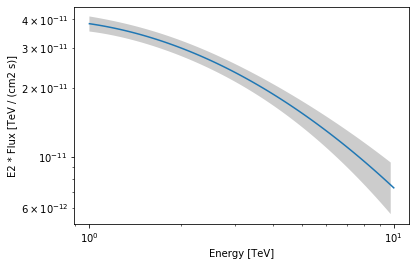

In [9]:
energy_range = [1, 10] * u.TeV
crab_spectrum.plot(energy_range=energy_range, energy_power=2)
ax = crab_spectrum.plot_error(energy_range=energy_range, energy_power=2)

## Inspecting fit statistic profiles

To check the quality of the fit it is also useful to plot fit statistic profiles for specific parameters.
For this we use `~gammapy.modeling.Fit.stat_profile()`.

In [10]:
profile = fit.stat_profile(parameter="alpha")

For a good fit and error estimate the profile should be parabolic, if we plot it:

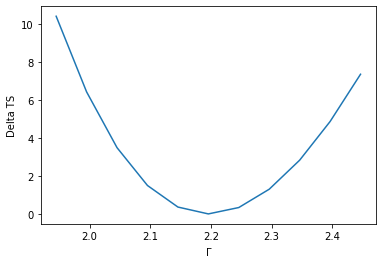

In [11]:
total_stat = result_minuit.total_stat
plt.plot(profile["values"], profile["stat"] - total_stat)
plt.xlabel(r"$\Gamma$")
plt.ylabel("Delta TS");

## Confidence contours


In most studies, one wishes to estimate parameters distribution using observed sample data.
A confidence interval gives an estimated range of values which is likely to include an unknown parameter.
The selection of a confidence level for an interval determines the probability that the confidence interval produced will contain the true parameter value.
A confidence contour is a 2D generalization of a confidence interval, often represented as an ellipsoid around the best-fit value.

After the fit, MINUIT offers the possibility to compute the confidence confours.
gammapy provides an interface to this functionnality throught the `Fit` object using the `minos_contour` method.
Here we defined a function to automatize the contour production for the differents parameterer and confidence levels (expressed in term of sigma):


In [12]:
def make_contours(fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(["alpha", "beta", "amplitude"], r=2):
            contour = fit.minos_contour(
                result.parameters[par_1],
                result.parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{par_1}_{par_2}"] = {
                par_1: contour["x"].tolist(),
                par_2: contour["y"].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

Now we can compute few contours.

In [13]:
%%time
sigma = [1, 2]
cts_sigma = make_contours(fit, result_minuit, 10, sigma)

CPU times: user 9.55 s, sys: 70.3 ms, total: 9.62 s
Wall time: 9.76 s


Then we prepare some aliases and annotations in order to make the plotting nicer.

In [14]:
pars = {
    "phi": r"$\phi_0 \,/\,(10^{-11}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$",
    "alpha": r"$\alpha$",
    "beta": r"$\beta$",
}

panels = [
    {
        "x": "alpha",
        "y": "phi",
        "cx": (lambda ct: ct["contour_alpha_amplitude"]["alpha"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_alpha_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "beta",
        "y": "phi",
        "cx": (lambda ct: ct["contour_beta_amplitude"]["beta"]),
        "cy": (
            lambda ct: np.array(1e11)
            * ct["contour_beta_amplitude"]["amplitude"]
        ),
    },
    {
        "x": "alpha",
        "y": "beta",
        "cx": (lambda ct: ct["contour_alpha_beta"]["alpha"]),
        "cy": (lambda ct: ct["contour_alpha_beta"]["beta"]),
    },
]

Finally we produce the confidence contours figures.

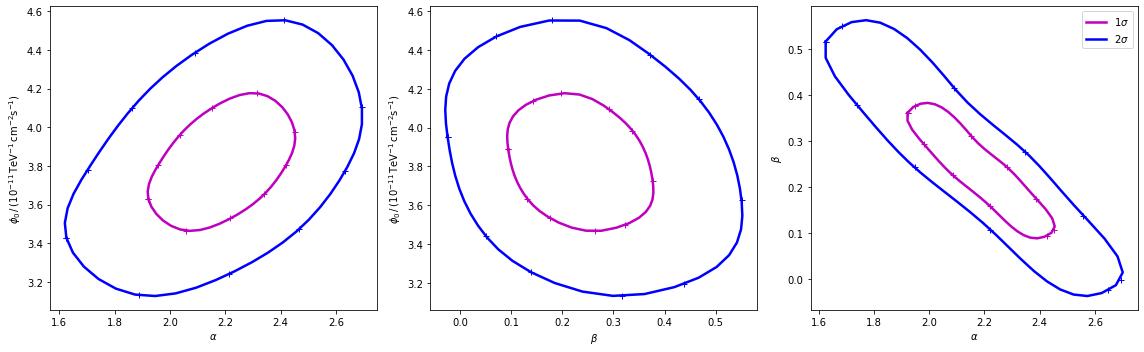

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = ["m", "b", "c"]
for p, ax in zip(panels, axes):
    xlabel = pars[p["x"]]
    ylabel = pars[p["y"]]
    for ks in range(len(cts_sigma)):
        plot_contour_line(
            ax,
            p["cx"](cts_sigma[ks]),
            p["cy"](cts_sigma[ks]),
            lw=2.5,
            color=colors[ks],
            label=f"{sigma[ks]}" + r"$\sigma$",
        )
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
plt.legend()
plt.tight_layout()